# TP1 : EDP

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib as mpl
import time
import scipy.stats as stats
import pandas as pd
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

mpl.rcParams['figure.dpi'] = 125

# Explicit Euler

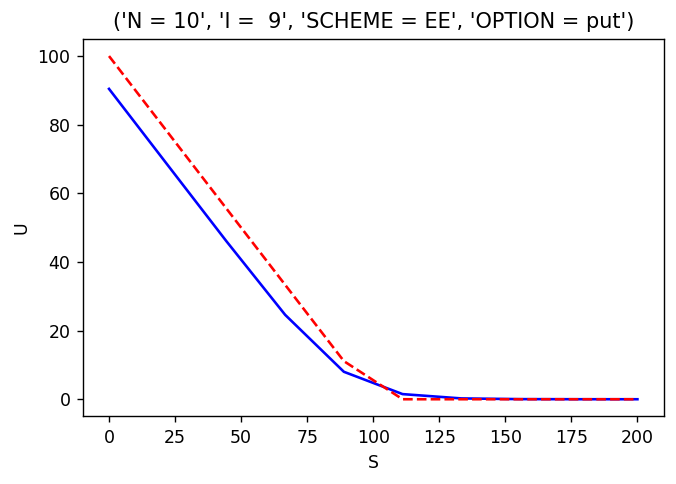

In [11]:
import numpy as np

class SchemePrice:
    def __init__(self, N, I, scheme = "EE", option = "put"):
        self.r = 0.1
        self.sigma = 0.2
        self.K = 100
        self.T = 1
        self.N = int(N)
        self.I = int(I)
        self.SCHEME = scheme
        self.option = option
        self.Smin = 0
        self.Smax = 200
        self.h = (self.Smax - self.Smin) / self.I
        self.dt = self.T / self.N
        self.S = np.arange(self.Smin, self.Smax + self.h, self.h)
        self.time = np.arange(0, self.T + self.dt, self.dt)
        self.A = self.createA()
        self.U = self.createU()
        self.U0 = self.u0(self.S)
        self.SCHEME = scheme
        self.title = 'N =%3i'%self.N,'I =%3i'%self.I,'SCHEME = %s'%self.SCHEME, 'OPTION = %s'%self.option
        self.mu = (self.dt/self.h**2)*self.sigma**2*self.Smax**2
        self.tcpu = 0
        self.solved = False
                            
    def plot(self):
        self.checkSolved()
        plt.plot(self.S, self.U, color='blue')  # Set color for the first curve
        plt.plot(self.S, self.U0, linestyle="--", color='red')  # Set color for the second curve
        plt.title(self.title)
        plt.xlabel("S")
        plt.ylabel("U")
        plt.show()

    def checkSolved(self):
        if not self.solved:
            self.U = self.solve()
    
    def Ind(self, a, b, x):
        return np.where((a <= x) & (x <= b), 1, 0)

    def u0(self, s):
        if self.option == "put":
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)
        elif self.option == "call":
            return np.maximum(0, s - self.K) * self.Ind(self.Smin, self.Smax, s)

    def uleft(self, t):
        if self.option == "put":
            return self.K * np.exp(-self.r * t) - self.Smin
        elif self.option == "call":
            return 0

    def uright(self, t):
        if self.option == "put":
            return 0
        elif self.option == "call":
            return self.Smax - self.K * np.exp(-self.r * t)

    def s(self, j):
        return self.Smin + j * self.h

    def alpha(self, j):
        return self.sigma**2 * self.s(j)**2 / (2 * self.h**2)

    def beta(self, j):
        return self.r * self.s(j) / (2 * self.h)
    
    def interpolate(self, s):
        self.checkSolved()
        s_index = np.argmax(self.S >= s)
        return ((self.S[s_index] - s)/self.h * self.U[s_index-1] + (s - self.S[s_index-1])/self.h * self.U[s_index])[0]

    def createA(self):
        A = np.zeros((self.I + 1, self.I + 1))
        for i in range(self.I + 1):
            alpha = self.alpha(i)
            beta = self.beta(i)
            A[i, i] = 2 * alpha + self.r
            if i > 0:
                A[i, i - 1] = -alpha + beta
            if i < self.I:
                A[i, i + 1] = -alpha - beta
        return A

    def q(self, t):
        y = np.zeros(self.I + 1)
        y[0] = (-self.alpha(0) + self.beta(0)) * self.uleft(t)
        y[-1] = (-self.alpha(self.I) + self.beta(self.I)) * self.uright(t)
        return y.reshape(self.I + 1, 1)

    def createU(self):
        U = np.zeros(self.I + 1)
        U = self.u0(self.S)
        return U.reshape(self.I + 1, 1)
    
    def blackScholes(self, sbar):
        dplus=(np.log(sbar/self.K)+self.r+0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        dmoins=(np.log(sbar/self.K)+self.r-0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        vbar=np.exp(-self.r*self.T)*self.K*stats.norm.cdf(-dmoins)-sbar*stats.norm.cdf(-dplus)
        return vbar

    def solve(self):
        t0 = time.time()
        theta = 0.5 if self.SCHEME == "CR" else 0
        reverse = self.option == "call"

        for n in (range(self.N-1, -1, -1) if reverse else range(self.N)):
            F = -(theta * self.q(self.time[n + 1]) + (1 - theta) * self.q(self.time[n])) if self.SCHEME == "CR" else None
            part1 = self.U - (1 - theta) * self.dt * (self.A @ self.U) if self.SCHEME == "CR" else None

            if self.SCHEME == "EE":
                self.U = self.U - self.dt * (self.A @ self.U + self.q(self.time[n]))
            elif self.SCHEME in ["IE", "CR"]:
                A_effective = np.identity(self.I + 1) + theta * self.dt * self.A
                b_effective = self.dt * F + part1 if self.SCHEME == "CR" else -self.dt * self.q(self.time[n]) + self.U
                self.U = np.linalg.solve(A_effective, b_effective)

        self.tcpu = time.time() - t0
        return self.U

    
def stabilityTable(scheme, s, Ns, Is, pricer = SchemePrice):

    Us = []
    tcpus = []
    hs = []

    for I in Is:
        N = I
        ee = pricer(N, I, scheme)
        U = ee.interpolate(s)
        Us.append(U)
        hs.append(ee.h)
        tcpus.append(ee.tcpu)


    df = pd.DataFrame({'I': Is, 'N': Ns, 'U(s)': Us})
    df['error'] = np.abs(df['U(s)'].shift() - df['U(s)'])
    df['h'] = hs
    df['alpha'] = np.log(df['error'].shift()/df['error'])/np.log(df['h'].shift()/df['h'])
    df['errex'] = np.abs(df['U(s)'] - ee.blackScholes(s))
    df['alphax'] = np.log(df['errex'].shift()/df['errex'])/np.log(df['h'].shift()/df['h'])

    df['tcpu'] = tcpus
    df = df.drop('h', axis=1)

    return df

SchemePrice(10, 9, "EE").plot()

## Numerical tests

### a)

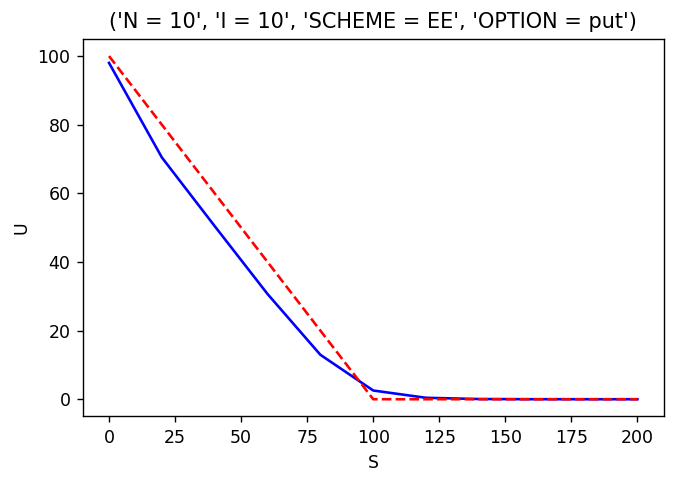

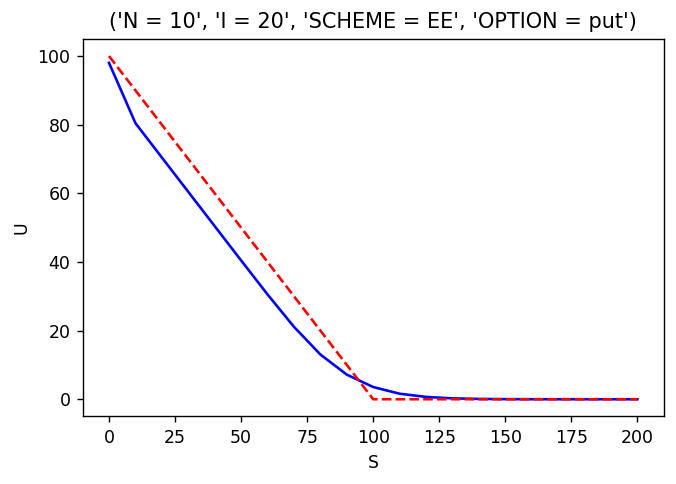

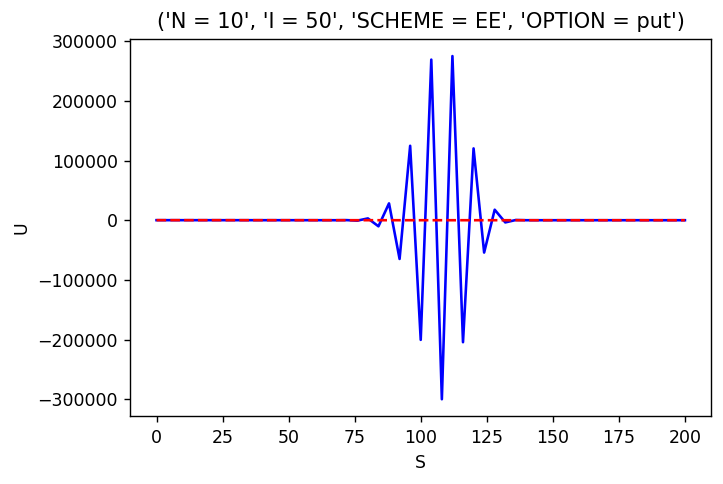

In [227]:
N = 10
Is = [10, 20, 50]

for i in Is:
    I = i
    SchemePrice(N, I).plot()

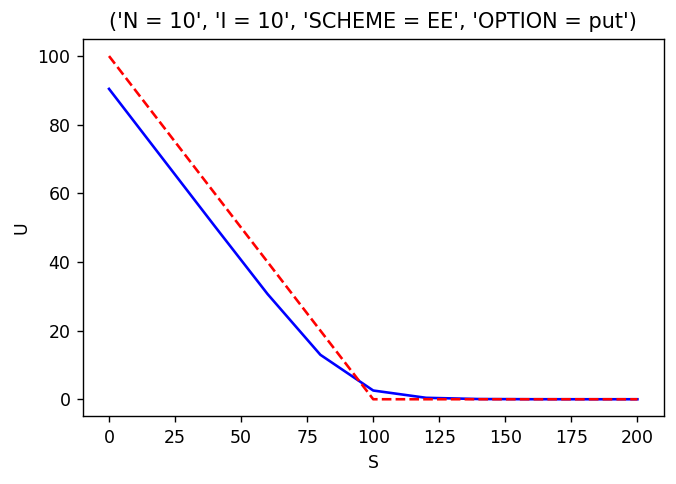

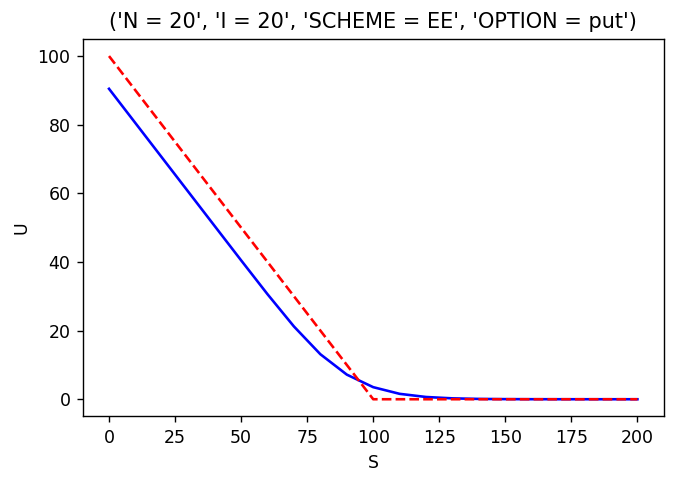

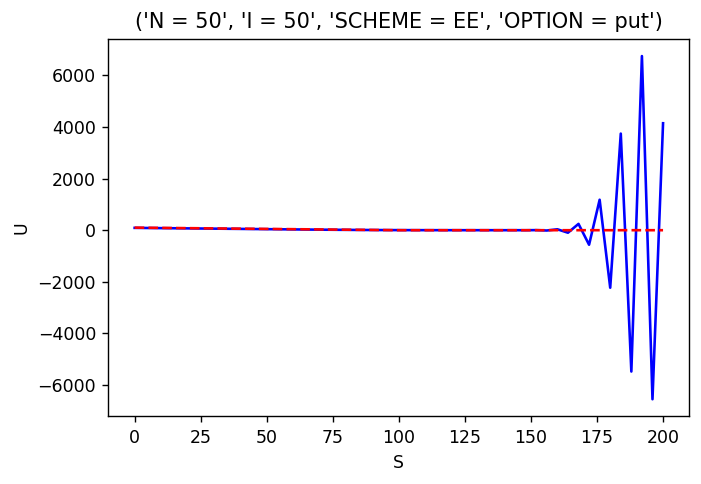

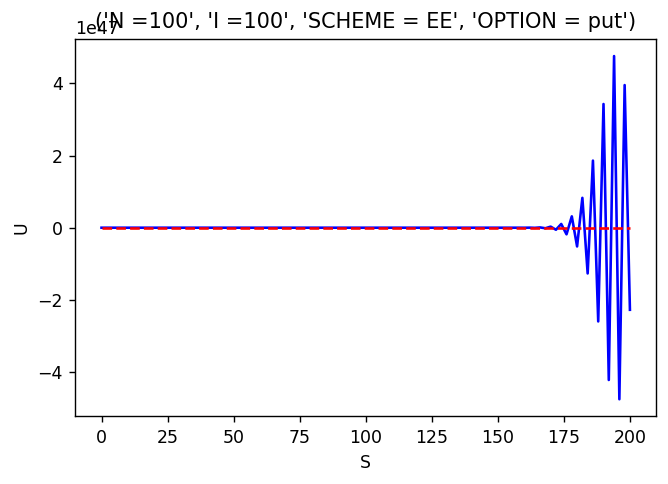

In [222]:
Is = [10, 20, 50, 100]
for i in Is:
    I = i
    N = i
    SchemePrice(N, I).plot()

### b)

In [223]:
N = 10
I = 50

ee = SchemePrice(N, I)
A = ee.A
B = np.eye(I+1) - ee.dt*A

np.set_printoptions(precision=2, suppress=True)

print("B : ")
print(B)

B : 
[[ 0.99  0.    0.   ...  0.    0.    0.  ]
 [-0.    0.99  0.01 ...  0.    0.    0.  ]
 [ 0.   -0.    0.97 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ... -8.23  4.85  0.  ]
 [ 0.    0.    0.   ...  4.56 -8.61  5.05]
 [ 0.    0.    0.   ...  0.    4.75 -9.01]]


In [167]:
print("Nombre de valeurs de B négatives : ", len(B[np.where(B < 0)]))
print("Nombre de valeurs de B positives : ", len(B[np.where(B > 0)]))
print("Nombre de valeurs de B > 1 : ", len(B[np.where(np.abs(B) > 1)]))
print("Norme infinie :", np.linalg.norm(B, np.inf))
print("Norme 2 :", np.linalg.norm(B, 2))

Nombre de valeurs de B négatives :  37
Nombre de valeurs de B positives :  113
Nombre de valeurs de B > 1 :  83
Norme infinie : 18.218000000000004
Norme 2 : 16.473976044293305


In [168]:
N = 10
I = 10

ee = SchemePrice(N, I)
A = ee.A
B = np.eye(I+1) - ee.dt*A
np.set_printoptions(precision=2, suppress=True)

print("B : ")
print(B)

B : 
[[ 0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.    0.99  0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.    0.97  0.02  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.95  0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.01  0.93  0.05  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.03  0.89  0.08  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.04  0.85  0.1   0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.06  0.79  0.13  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.09  0.73  0.17  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.12  0.67  0.21]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.15  0.59]]


In [169]:
print("Nombre de valeurs de B négatives : ", len(B[np.where(B < 0)]))
print("Nombre de valeurs de B positives : ", len(B[np.where(B > 0)]))
print("Nombre de valeurs de B > 1 : ", len(B[np.where(np.abs(B) > 1)]))
print("Norme infinie :", np.linalg.norm(B, np.inf))
print("Norme 2 :", np.linalg.norm(B, 2))

Nombre de valeurs de B négatives :  2
Nombre de valeurs de B positives :  28
Nombre de valeurs de B > 1 :  0
Norme infinie : 0.996
Norme 2 : 0.9905600478087734


## c)

In [170]:
NIs = [(10, 10), (10, 50)]

for N, I in NIs:
    
    print(f"Mu for I = {I}, N = {N} is {SchemePrice(N, I).mu}")

Mu for I = 10, N = 10 is 0.4000000000000001
Mu for I = 50, N = 10 is 10.000000000000002


## d)

In [171]:
N = 10
I = 10
print(SchemePrice(N, I).interpolate(90))

7.748163083043563


## e)

In [172]:
stabilityTable("EE", 80, [10, 20, 40, 80, 160, 320], [10, 20, 40, 80, 160, 320])

,I,N,U(s),error,alpha,errex,alphax,tcpu
0,10,10,1.295175e+01,NaN,NaN,3.219137e-01,NaN,0.000000
1,20,20,1.311311e+01,1.613577e-01,NaN,1.605560e-01,1.003598,0.000000
2,40,40,1.321452e+01,1.014162e-01,0.669975,5.913981e-02,1.440875,0.001032
3,80,80,-8.754892e+02,8.887038e+02,-13.097199,8.887629e+02,-13.875381,0.011065
4,160,160,-1.082407e+69,1.082407e+69,-219.531723,1.082407e+69,-219.531627,0.029929
5,320,320,NaN,NaN,NaN,NaN,NaN,0.266453


In [173]:
Is = [10, 20, 40, 80, 160, 320]
Ns = np.array(Is)**2/10
stabilityTable("EE", 80, Ns, Is)

,I,N,U(s),error,alpha,errex,alphax,tcpu
0,10,10.0,1.295175e+01,NaN,NaN,3.219137e-01,NaN,0.001504
1,20,40.0,1.311311e+01,1.613577e-01,NaN,1.605560e-01,1.003598,0.000000
2,40,160.0,1.321452e+01,1.014162e-01,0.669975,5.913981e-02,1.440875,0.001201
3,80,640.0,-8.754892e+02,8.887038e+02,-13.097199,8.887629e+02,-13.875381,0.010066
4,160,2560.0,-1.082407e+69,1.082407e+69,-219.531723,1.082407e+69,-219.531627,0.029085
5,320,10240.0,NaN,NaN,NaN,NaN,NaN,0.272820


# Implicit Euler

## a)

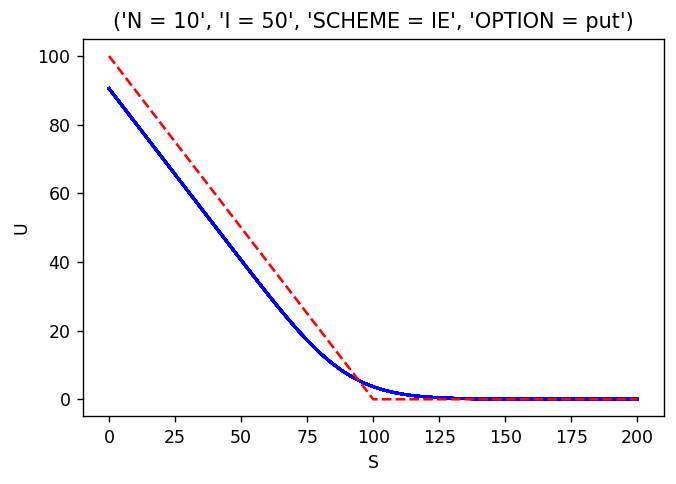

In [174]:
N = 10
I = 50

SchemePrice(N, I, "IE").plot()

## b)

In [175]:
Is = [10, 20, 40, 80, 160, 320, 640]
Ns = np.array(Is)/10
stabilityTable("IE", 80, Ns, Is)

,I,N,U(s),error,alpha,errex,alphax,tcpu
0,10,1.0,13.248806,NaN,NaN,0.024857,NaN,0.001005
1,20,2.0,13.259841,0.011035,NaN,0.013822,0.846704,0.005001
2,40,4.0,13.282481,0.022640,-1.036765,0.008818,0.648397,0.021436
3,80,8.0,13.283848,0.001367,4.049959,0.010185,-0.207896,0.090214
4,160,16.0,13.280321,0.003527,-1.367556,0.006658,0.613262,0.443740
5,320,32.0,13.277393,0.002928,0.268505,0.003730,0.835876,2.061384
6,640,64.0,13.275629,0.001764,0.731130,0.001966,0.923779,10.150822


# Crank Nicolson

## a)

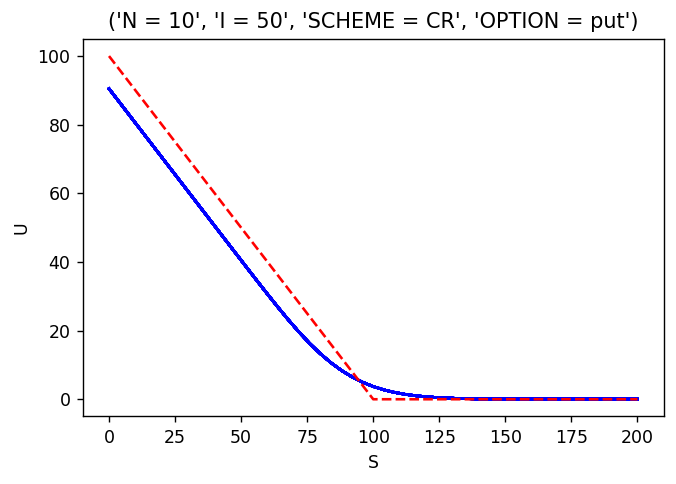

In [176]:
N = 10
I = 50

SchemePrice(N, I, "CR").plot()

## b)

In [177]:
Is = [10, 20, 40, 80, 160, 320]
Ns = np.array(Is)/10

stabilityTable("CR", 80, Ns, Is)

,I,N,U(s),error,alpha,errex,alphax,tcpu
0,10,1.0,13.103161,NaN,NaN,0.170502,NaN,0.002009
1,20,2.0,13.186437,0.083276,NaN,0.087226,0.966956,0.004662
2,40,4.0,13.248364,0.061927,0.427331,0.025299,1.785668,0.021745
3,80,8.0,13.267160,0.018797,1.720094,0.006503,1.960003,0.099541
4,160,16.0,13.272027,0.004866,1.949521,0.001636,1.990739,0.398277
5,320,32.0,13.273253,0.001226,1.988397,0.000410,1.997728,1.948629


# Numerical tests conclusion


La méthode d'Euler explicite était instable pour des valeurs élevées de I et N. Nous avons donc mis en œuvre les méthodes d'Euler implicite et de Cranck Nicolson qui elles gardent une grande stabilité, ce que l'on a pu observer avec les variables **error**, **errex**, **alpha** et que l'on pouvait prédire avec un $\text{CFL} = \frac{\Delta t}{h^2}\sigma^2 S_{max}^2$ assez faible. <Br>
De plus le temps de calcul était assez raisonbale comme on peut le voir dans la table avec la variable **tcpu**. <Br>
La variable **alpha** nous donne l'ordre numérique de chaque méthode et on obtient bien ce à quoi on pouvait s'attendre avec la théorie, c'est à dire : <Br>

| Méthode | Ordre |
|---------|-------|
| EE      | 1     |
| IE      | 1     |
| CR      | 2     |


# Complément 1

La variable **alphax** est l'ordre calculé en utilisant l'erreur calculée avec Black Scholes. On ne voit pas de changement d'ordre. 

# Complément 2

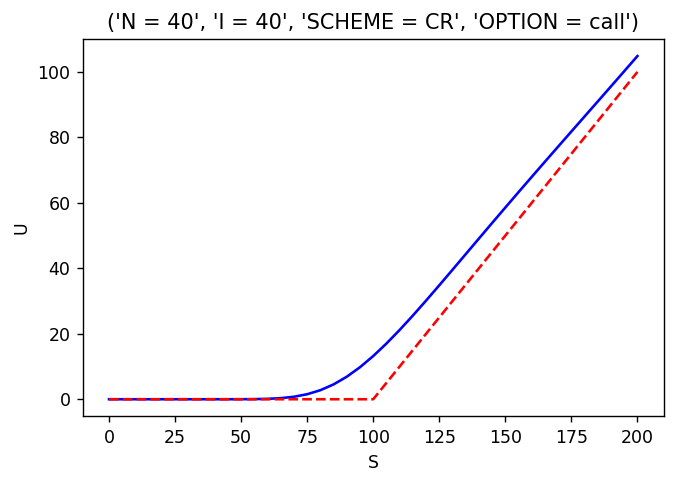

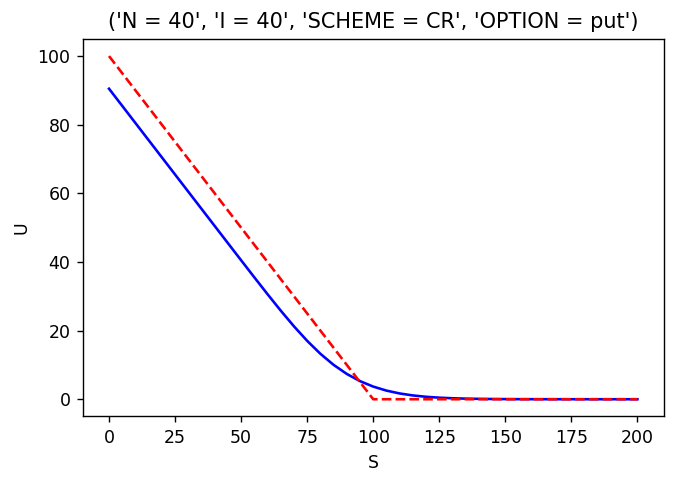

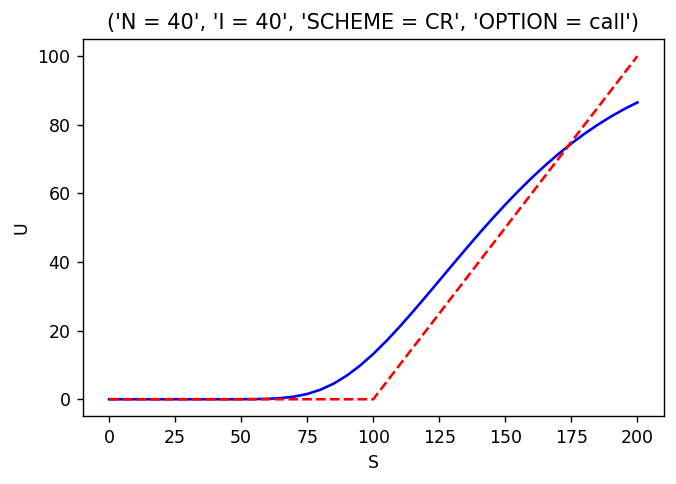

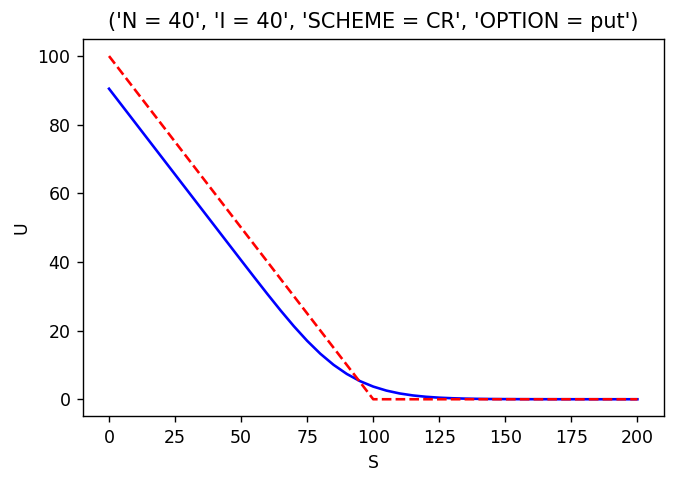

In [6]:
from scipy import sparse as sparse
from scipy.sparse.linalg import spsolve

class SchemePriceSparse:
    def __init__(self, N, I, scheme = "EE", option = "put"):
        self.r = 0.1
        self.sigma = 0.2
        self.K = 100
        self.T = 1
        self.N = int(N)
        self.I = int(I)
        self.SCHEME = scheme
        self.option = option
        self.Smin = 0
        self.Smax = 200
        self.h = (self.Smax - self.Smin) / self.I
        self.dt = self.T / self.N
        self.S = np.arange(self.Smin, self.Smax + self.h, self.h)
        self.time = np.arange(0, self.T + self.dt, self.dt)
        self.A = self.createA()
        self.U = self.createU()
        self.U0 = self.u0(self.S)
        self.title = 'N =%3i' % self.N, 'I =%3i' % self.I, 'SCHEME = %s' % self.SCHEME, 'OPTION = %s' % self.option
        self.mu = (self.dt / self.h ** 2) * self.sigma ** 2 * self.Smax ** 2
        self.tcpu = 0
        self.solved = False
                            
    def plot(self):
        self.checkSolved()
        plt.plot(self.S, self.U, color='blue')  # Set color for the first curve
        plt.plot(self.S, self.U0, linestyle="--", color='red')  # Set color for the second curve
        plt.title(self.title)
        plt.xlabel("S")
        plt.ylabel("U")
        plt.show()

    def checkSolved(self):
        if not self.solved:
            self.U = self.solve()
    
    def Ind(self, a, b, x):
        return np.where((a <= x) & (x <= b), 1, 0)

    def u0(self, s):
        if self.option == "put":
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)
        elif self.option == "call":
            return np.maximum(0, s - self.K) * self.Ind(self.Smin, self.Smax, s)

    def s(self, j):
        return self.Smin + j * self.h

    def alpha(self, j):
        return self.sigma**2 * self.s(j)**2 / (2 * self.h**2)

    def beta(self, j):
        return self.r * self.s(j) / (2 * self.h)
    
    def interpolate(self, s):
        self.checkSolved()
        s_index = np.argmax(self.S >= s)
        return ((self.S[s_index] - s)/self.h * self.U[s_index-1] + (s - self.S[s_index-1])/self.h * self.U[s_index])[0]

    def createA(self):
        A = sparse.lil_matrix((self.I + 1, self.I + 1))
        for i in range(self.I + 1):
            alpha = self.alpha(i)
            beta = self.beta(i)
            A[i, i] = 2 * alpha + self.r
            if i > 0:
                A[i, i - 1] = -alpha + beta
            if i < self.I:
                A[i, i + 1] = -alpha - beta
        return A.todia()

    def createU(self):
        if self.option == "put":
            return np.maximum(0, self.K - self.S).reshape(-1, 1)
        elif self.option == "call":
            return np.maximum(0, self.S - self.K).reshape(-1, 1)

    def q(self, t):
        y = np.zeros(self.I + 1)
        if self.option == "put":
            y[0] = (-self.alpha(0) + self.beta(0)) * self.uleft(t)
            y[-1] = 0
        elif self.option == "call":
            y[0] = 0
            y[-1] = (-self.alpha(self.I) - self.beta(self.I)) * self.uright(t)
        return y.reshape(-1, 1)

    def uleft(self, t):
        if self.option == "put":
            return self.K * np.exp(-self.r * t) - self.Smin
        elif self.option == "call":
            return 0

    def uright(self, t):
        if self.option == "put":
            return 0
        elif self.option == "call":
            return self.Smax - self.K * np.exp(-self.r * (self.T - t))
    
    def blackScholes(self, sbar):
        dplus=(np.log(sbar/self.K)+self.r+0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        dmoins=(np.log(sbar/self.K)+self.r-0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        vbar=np.exp(-self.r*self.T)*self.K*stats.norm.cdf(-dmoins)-sbar*stats.norm.cdf(-dplus)
        return vbar

    def solve(self):
        t0 = time.time()
        identity = sparse.identity(self.I + 1, format="csr")
        self.U = self.createU()

        for n in range(self.N-1, -1, -1):
            q_val = self.q(self.time[n])

            if self.SCHEME == "EE":
                self.U = self.U - self.dt * (self.A.dot(self.U) + q_val)
            elif self.SCHEME == "IE":
                self.U = spsolve(identity + self.dt * self.A, self.U - self.dt * q_val)
                self.U = self.U.reshape(-1, 1)
            elif self.SCHEME == "CR":
                theta = 0.5
                F = -(theta * self.q(self.time[n + 1]) + (1 - theta) * q_val)
                part1 = self.U - (1 - theta) * self.dt * (self.A.dot(self.U))
                self.U = spsolve(identity + theta * self.dt * self.A, part1 + self.dt * F)
                self.U = self.U.reshape(-1, 1)

        self.tcpu = time.time() - t0
        return self.U


SchemePriceSparse(40, 40, "CR", "call").plot()
SchemePriceSparse(40, 40, "CR", "put").plot()

SchemePrice(40, 40, "CR", "call").plot()
SchemePrice(40, 40, "CR", "put").plot()

In [273]:

Is = [10, 20, 40, 80, 160, 320]
Ns = np.array(Is)/10

df_normal = stabilityTable("CR", 80, Ns, Is, pricer = SchemePrice)
df_sparse = stabilityTable("CR", 80, Ns, Is, pricer = SchemePriceSparse)

,I,N,U(s),error,alpha,errex,alphax,tcpu,NI
0,10,1.0,13.103161,NaN,NaN,0.170502,NaN,0.000999,"(1, 10)"
1,20,2.0,13.186437,0.083276,NaN,0.087226,0.966956,0.003015,"(2, 20)"
2,40,4.0,13.248364,0.061927,0.427331,0.025299,1.785668,0.063203,"(4, 40)"
3,80,8.0,13.267160,0.018797,1.720094,0.006503,1.960003,0.633906,"(8, 80)"
4,160,16.0,13.272027,0.004866,1.949521,0.001636,1.990739,2.209315,"(16, 160)"
5,320,32.0,13.273253,0.001226,1.988397,0.000410,1.997728,9.284592,"(32, 320)"


,I,N,U(s),error,alpha,errex,alphax,tcpu,NI
0,10,1.0,13.103161,NaN,NaN,0.170502,NaN,0.004514,"(1, 10)"
1,20,2.0,13.186437,0.083276,NaN,0.087226,0.966957,0.007140,"(2, 20)"
2,40,4.0,13.248364,0.061927,0.427333,0.025299,1.785668,0.014898,"(4, 40)"
3,80,8.0,13.267160,0.018797,1.720094,0.006503,1.960003,0.032246,"(8, 80)"
4,160,16.0,13.272027,0.004866,1.949521,0.001636,1.990739,0.065060,"(16, 160)"
5,320,32.0,13.273253,0.001226,1.988397,0.000410,1.997728,0.135291,"(32, 320)"


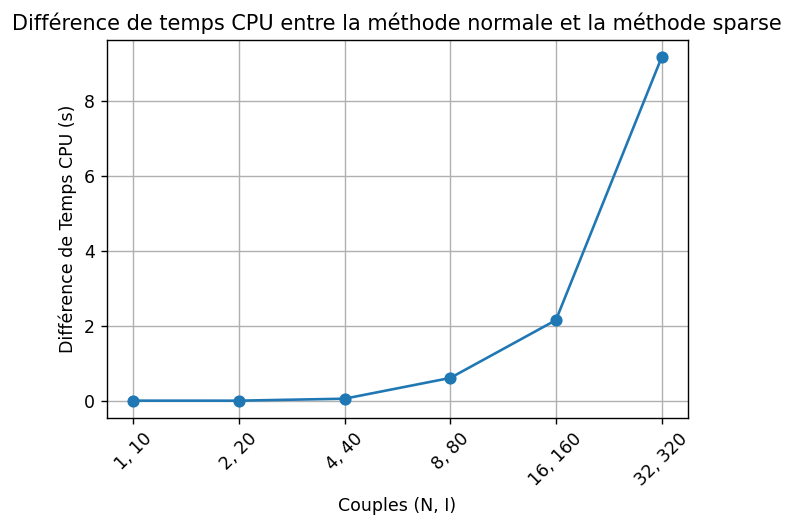

In [278]:
display(df_normal)
display(df_sparse)

df_normal['NI'] = df_normal.apply(lambda row: (int(row['N']), int(row['I'])), axis=1)
df_sparse['NI'] = df_sparse.apply(lambda row: (int(row['N']), int(row['I'])), axis=1)

normal_tcpu = df_normal[['NI', 'tcpu']].set_index('NI')
sparse_tcpu = df_sparse[['NI', 'tcpu']].set_index('NI')

diff_df = normal_tcpu.subtract(sparse_tcpu, axis=0)

# Ajouter une colonne pour les étiquettes de l'axe des x
diff_df['NI_str'] = diff_df.index.map(lambda x: f"{x[0]}, {x[1]}")

# Tracé de la différence
plt.plot(diff_df['NI_str'], diff_df['tcpu'], marker='o')
plt.title('Différence de temps CPU entre la méthode normale et la méthode sparse')
plt.xlabel('Couples (N, I)')
plt.ylabel('Différence de Temps CPU (s)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

On observe une très bonne amélioration des temps de calcul.

# Complément 3

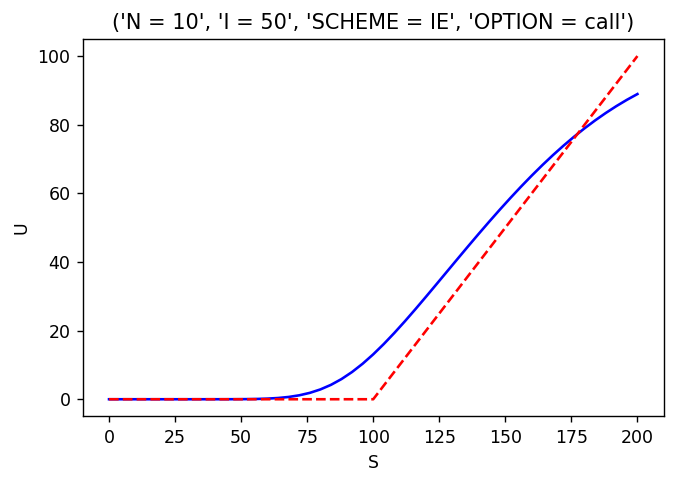

In [277]:
N = 10
I = 50

SchemePrice(N, I, "IE", "call").plot()

### Méthode de Calcul pour les Options Call

La tarification des options call peut être effectuée en utilisant des méthodes numériques pour résoudre l'équation différentielle partielle (EDP) de Black-Scholes. Les méthodes couramment utilisées sont les schémas d'Euler explicite (EE), d'Euler implicite (IE) et de Crank-Nicolson (CR). 

#### Conditions Initiales et aux Limites

Pour une option call, la valeur de l'option dépend du prix actuel de l'actif sous-jacent $S$, du prix d'exercice $K$, du taux d'intérêt sans risque $r$, de la volatilité $\sigma$, et du temps restant jusqu'à l'échéance $T$. 

La **condition initiale** (car on itère à partir de $T$) à l'échéance $t = T$ est donnée par :

$$ 
U(S, T) = \max(S - K, 0)
$$

Les **conditions aux limites** sont :

- Pour $S \rightarrow S_{min}$ : $U(0, t) = 0$
- Pour $S \rightarrow S_{max}$ : $U(S, t) \approx S_{max} - Ke^{-rt}$

#### Schéma Numérique

Dans les schémas numériques, l'intervalle de temps est discrétisé en $N$ pas, et l'intervalle de prix de l'actif sous-jacent est discrétisé en $I$ pas. 

- **Euler Explicite (EE)** : Le calcul se fait directement en utilisant la valeur de l'option à l'étape précédente.
  
  $$
  U^{n+1} = U^n - \Delta t \cdot (A U^n + q(t_n))
  $$

- **Euler Implicite (IE)** : Il nécessite la résolution d'un système linéaire à chaque étape temporelle.
  
  $$
  (I + \Delta t \cdot A) U^{n+1} = U^n - \Delta t \cdot q(t_{n+1})
  $$

- **Crank-Nicolson (CR)** : Combine les approches explicite et implicite.
  
  $$
  (I + \theta \Delta t \cdot A) U^{n+1} = U^n - \Delta t \cdot [(1-\theta)(A U^n + q(t_n)) + \theta q(t_{n+1})]
  $$
  
  où $\theta = 0.5$.

Dans ces formules, $A$ est une matrice représentant les termes de différenciation spatiale de l'EDP, et $q(t)$ représente les termes sources, y compris les conditions aux limites.

#### Implémentation

En implémentation, des matrices creuses (sparse matrices) sont utilisées pour $A$ afin d'optimiser la performance, surtout pour des grilles de calculs larges. Les calculs sont effectués en Python en utilisant des bibliothèques telles que `numpy` pour les opérations matricielles et `scipy.sparse` pour les matrices creuses et la résolution de systèmes linéaires.
